<a href="https://colab.research.google.com/github/altdff/APT-clustering-CREF/blob/main/APT_clustering_CREF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Declarations

In [1]:
!pip install pyclustering
import pandas as pd # dataframe manipulation
import numpy as np # linear algebra

# data visualization
import matplotlib.pyplot as plt
%matplotlib inline
from yellowbrick.cluster import KElbowVisualizer # cluster visualizer

# sklearn kmeans
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.decomposition import NMF
from sklearn.mixture import GaussianMixture
from sklearn.manifold import TSNE
from sklearn.metrics.cluster import contingency_matrix

# pyclustering kmeans
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import distance_metric
from pyclustering.cluster.center_initializer import random_center_initializer
from pyclustering.cluster.encoder import type_encoding
from pyclustering.cluster.encoder import cluster_encoder

# Step 0: Import necessary libraries

import subprocess
import sys

# List of packages to install
packages = [
    'pandas',
    'scikit-learn',
    'scipy',
    'matplotlib',
    'seaborn',
    'numpy',
    'scikit-learn-extra',
    'mitreattack-python',
    'requests',
    'openai'
]

try:
    # Install packages silently
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', '--quiet', '--no-input'] + packages)
    print("Packages installed successfully.")
except subprocess.CalledProcessError as e:
    print(f"An error occurred while installing packages: {e}")

# Import statements
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, MeanShift, Birch
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
#from sklearn_extra.cluster import KMedoids

from openai import OpenAI

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
from mitreattack.stix20 import MitreAttackData
import tempfile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyclustering: filename=pyclustering-0.10.1.2-py3-none-any.whl size=2395100 sha256=ec6247a2dabfd1f9e08e32f5fd14c182472b60495ca9f032612d0528e4680bc9
  Stored in directory: /root/.cache/pip/wheels/68/29/b4/131bd7deec3663cc311ab9aa64d6517c3e3ec24bcadfc32f74
Successfully built pyclustering
Packages installed successfully.


# Data cleaning and preparation

In [7]:
# Step 1: Read the dataset

ATTACK_TECHNIQUES_URL = "https://raw.githubusercontent.com/mitre/cti/master/enterprise-attack/enterprise-attack.json"
response = requests.get(ATTACK_TECHNIQUES_URL)
response.raise_for_status()  # Ensure we notice bad responses
data = response.json()

# Save the JSON data to a temporary file
with tempfile.NamedTemporaryFile(mode='w+', suffix='.json', delete=False) as temp_file:
    import json
    json.dump(data, temp_file)
    temp_file_path = temp_file.name

# Load the MITRE ATT&CK data using the temporary file
mitre_attack_data = MitreAttackData(temp_file_path)
techniques_used_by_groups = mitre_attack_data.get_all_techniques_used_by_all_groups()
mitigations_for_techniques = mitre_attack_data.get_all_mitigations_mitigating_all_techniques()

#--
from google.colab import drive
drive.mount('/content/drive')
file_path_CREF = '/content/drive/My Drive/APT Groupings and MITRE CREF v2/Code/attack-relationships-sankey-export.xlsx'
df_CREF = pd.read_excel(file_path_CREF)
#---

group_technique = []

for group_id, techniques_used in techniques_used_by_groups.items():
  for item in techniques_used:
    technique = item['object']
    technique_id = technique.id
    group_technique.append((mitre_attack_data.get_name(group_id), technique_id))

df = pd.DataFrame(group_technique, columns=['source ID', 'target ID'])
from IPython.display import display, HTML

# Assuming the first column is 'EntityID' and the second column is 'Attribute'
df.columns = ['source ID', 'target ID']

# Step 2: Preprocess the data
# Create a binary matrix
binary_matrix_master = pd.get_dummies(df, columns=['target ID'], prefix='', prefix_sep='').groupby('source ID').sum()
from IPython.display import display, HTML

# Step 3: Apply clustering algorithms

# Initialize an empty dictionary to store the labels
cluster_labels_master = {}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Measuring clusterability

Hopkins statistic: 0.7255088687347286


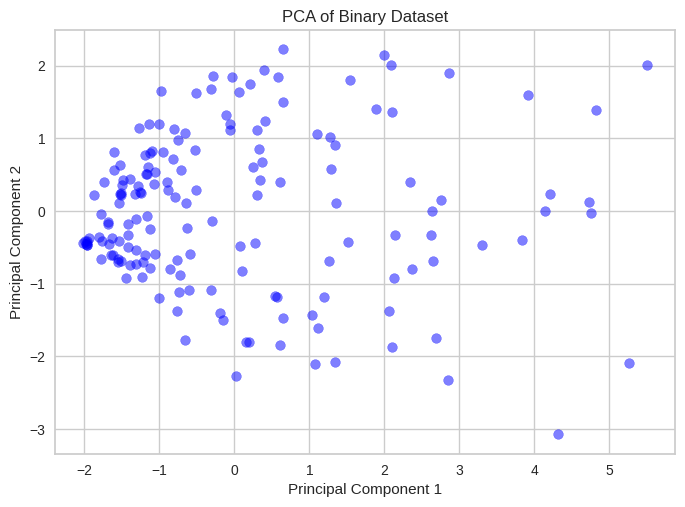

In [8]:
binary_matrix = binary_matrix_master.copy()
cluster_labels = cluster_labels_master.copy()

from sklearn.neighbors import NearestNeighbors
def hopkins_statistic(X, sample_size=None):
    if sample_size is None:
        sample_size = int(0.1 * X.shape[0])

    # Step 2: Randomly select sample points
    random_sample = X.sample(n=sample_size).values

    # Step 3: Generate synthetic points within the range of the dataset
    synthetic_sample = np.random.uniform(size=(sample_size, X.shape[1]))
    for i in range(X.shape[1]):
        min_val = X.iloc[:, i].min()
        max_val = X.iloc[:, i].max()
        synthetic_sample[:, i] = synthetic_sample[:, i] * (max_val - min_val) + min_val

    # Step 4: Calculate distances
    nbrs = NearestNeighbors(n_neighbors=2).fit(X.values)
    u_distances, _ = nbrs.kneighbors(random_sample, n_neighbors=2)
    w_distances, _ = nbrs.kneighbors(synthetic_sample, n_neighbors=1)

    u_distances = u_distances[:, 1]  # Exclude the 0 distance to itself
    w_distances = w_distances[:, 0]

    # Step 5: Compute Hopkins statistic
    hopkins_stat = np.sum(w_distances) / (np.sum(w_distances) + np.sum(u_distances))
    return hopkins_stat

# Example usage with a binary dataset
# Create a binary dataset
# data = {'feature1': np.random.randint(0, 2, 100), 'feature2': np.random.randint(0, 2, 100)}
df1 = pd.DataFrame(binary_matrix)

# Calculate Hopkins statistic
hopkins_stat = hopkins_statistic(df1)
print(f"Hopkins statistic: {hopkins_stat}")

# Applying PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df1)

# Scatter plot of PCA results
plt.scatter(pca_result[:, 0], pca_result[:, 1], c='blue', marker='o', alpha=0.5)
plt.title('PCA of Binary Dataset')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

# Determining optimal number of clusters

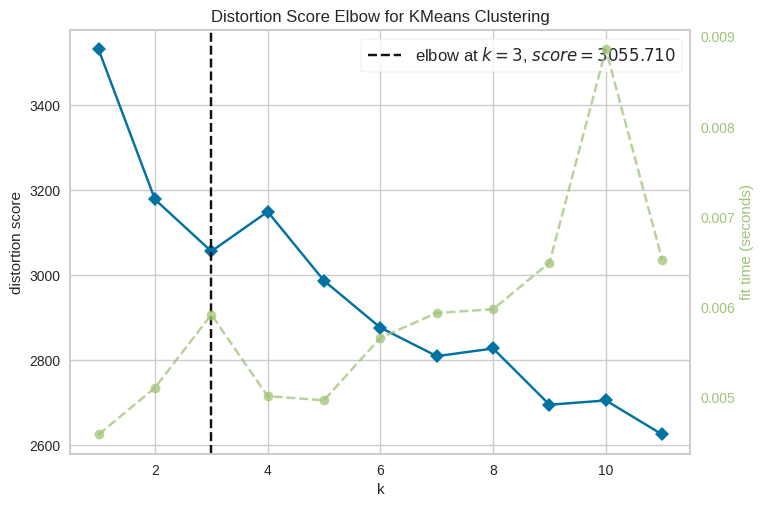

In [10]:
binary_matrix = binary_matrix_master.copy()
cluster_labels = cluster_labels_master.copy()

# Instantiate the clustering model and visualizer
model = KMeans()

visualizer = KElbowVisualizer(model, k=(1, 12))
pairwise_dist = pairwise_distances(binary_matrix.values, metric='hamming')

visualizer.fit(binary_matrix) # Fit the data to the visualizer
visualizer.show() # Finalize and render the figure
plt.show()

# Clustering - KMeans

<class 'pandas.core.frame.DataFrame'>
Index: 163 entries, APT-C-36 to menuPass
Columns: 478 entries, attack-pattern--005a06c6-14bf-4118-afa0-ebcd8aebb0c9 to attack-pattern--ffeb0780-356e-4261-b036-cfb6bd234335
dtypes: int64(478)
memory usage: 610.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 163 entries, APT-C-36 to menuPass
Columns: 478 entries, attack-pattern--005a06c6-14bf-4118-afa0-ebcd8aebb0c9 to attack-pattern--ffeb0780-356e-4261-b036-cfb6bd234335
dtypes: int64(478)
memory usage: 610.0+ KB
Silhouette Score: 0.3530407741366484
Davies-Bouldin Index: 0.5965342008562727
Calinski-Harabasz Score: 330.16271381598756


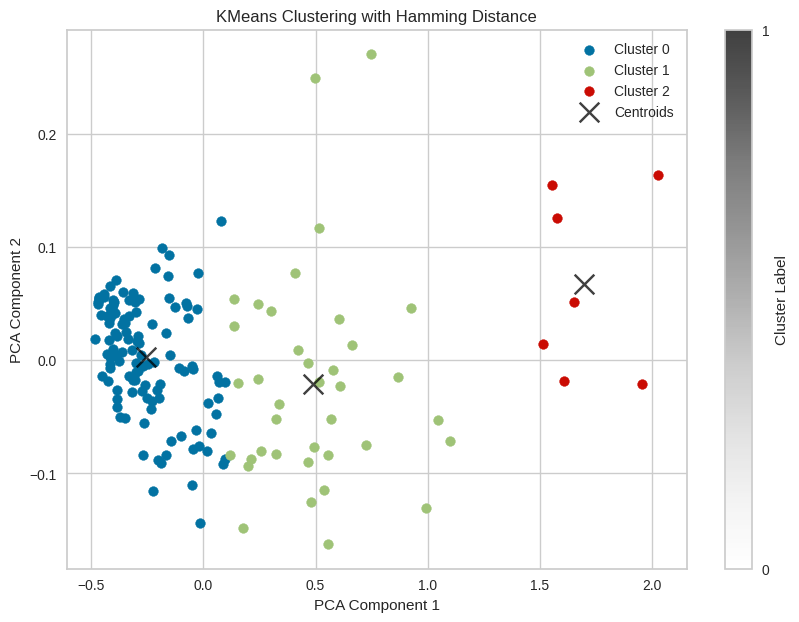

In [11]:
binary_matrix = binary_matrix_master.copy()
binary_matrix.info()
binary_matrix = binary_matrix.loc[:, (binary_matrix != 0).any(axis=0)]
binary_matrix.info()
cluster_labels = cluster_labels_master.copy()

# Calculate pairwise distance matrix
# cosine: Silhouette Score: 0.06379433334219603, Davies-Bouldin Index: 1.611227148762061, Calinski-Harabasz Score: 45.83931731263848
# hamming: Silhouette Score: 0.3435434593452596, Davies-Bouldin Index: 0.6338502875267814, Calinski-Harabasz Score: 299.804358788823
# canberra: Silhouette Score: 0.3435434593452596, Davies-Bouldin Index: 0.6338502875267814, Calinski-Harabasz Score: 299.804358788823
# manhattan: Silhouette Score: 0.3435434593452596, Davies-Bouldin Index: 0.6338502875267814, Calinski-Harabasz Score: 299.804358788823
# jaccard: Silhouette Score: 0.05070582314530339, Davies-Bouldin Index: 1.9210252330314856, Calinski-Harabasz Score: 27.32995954773474
# dice: Silhouette Score: 0.083998675378963, Davies-Bouldin Index: 1.460839601328787, Calinski-Harabasz Score: 48.84896215400138
# sokalmichener: Silhouette Score: 0.30749467285040627, Davies-Bouldin Index: 0.6584451158417889, Calinski-Harabasz Score: 291.2741801156684
# yule: Silhouette Score: 0.39176188651704724, Davies-Bouldin Index: 1.6359723213941082, Calinski-Harabasz Score: 41.89010764424859
pairwise_dist = pairwise_distances(binary_matrix.values, metric='hamming')

# Perform k-means clustering
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(pairwise_dist)
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
binary_matrix['Cluster']=labels

# Calculate evaluation metrics
silhouette_avg = silhouette_score(pairwise_dist, labels, metric='precomputed')
dbi = davies_bouldin_score(pairwise_dist, labels)
calinski_harabasz = calinski_harabasz_score(pairwise_dist, labels)

print(f'Silhouette Score: {silhouette_avg}')
print(f'Davies-Bouldin Index: {dbi}')
print(f'Calinski-Harabasz Score: {calinski_harabasz}')

# Perform PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(pairwise_dist)
pca_centroids = pca.transform(centroids)

# Plot PCA results
plt.figure(figsize=(10, 7))
unique_clusters = np.unique(labels)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# Plot data points
for cluster in unique_clusters:
    cluster_points = pca_components[labels == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[cluster % len(colors)], label=f'Cluster {cluster}')

# Plot centroids
plt.scatter(pca_centroids[:, 0], pca_centroids[:, 1], c='black', s=200, alpha=0.75, marker='x', label='Centroids')

plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('KMeans Clustering with Hamming Distance')
plt.legend()
plt.colorbar(ticks=range(num_clusters), label='Cluster Label')
plt.show()

# Finding top techniques per cluster

In [12]:
# Function to process the DataFrame
def process_clusters(df):
    results = {}
    for cluster in df['Cluster'].unique():
        # Subset the DataFrame by cluster
        sub_df = df[df['Cluster'] == cluster].drop(columns=['Cluster'])

        # Calculate the sum of each column
        col_sums = sub_df.sum()

        # Identify the top 5 columns with the highest sums
        top_cols = col_sums.nlargest(5)

        # Store the results
        results[cluster] = top_cols

    return results

# Process the clusters
results = process_clusters(binary_matrix)

# Display the results
for cluster, top_cols in results.items():
    print("Most frequent techniques per cluster")
    print("----------")
    print(f"Cluster {cluster}:")
    for col, value in top_cols.items():
        print(f"Technique/Subtechnique: {mitre_attack_data.get_name(col)} ({mitre_attack_data.get_attack_id(col)}), Appearances: {value}")
        parent = mitre_attack_data.get_attack_id(col).split('.')[0]
        print(f"Parent Technique: {parent}" )
#        get_parent_technique_of_subtechnique

Most frequent techniques per cluster
----------
Cluster 0:
Technique/Subtechnique: Malicious File (T1204.002), Appearances: 55
Parent Technique: T1204
Technique/Subtechnique: Spearphishing Attachment (T1566.001), Appearances: 52
Parent Technique: T1566
Technique/Subtechnique: Tool (T1588.002), Appearances: 45
Parent Technique: T1588
Technique/Subtechnique: Ingress Tool Transfer (T1105), Appearances: 45
Parent Technique: T1105
Technique/Subtechnique: PowerShell (T1059.001), Appearances: 40
Parent Technique: T1059
Most frequent techniques per cluster
----------
Cluster 2:
Technique/Subtechnique: Match Legitimate Resource Name or Location (T1036.005), Appearances: 7
Parent Technique: T1036
Technique/Subtechnique: Data from Local System (T1005), Appearances: 7
Parent Technique: T1005
Technique/Subtechnique: Deobfuscate/Decode Files or Information (T1140), Appearances: 7
Parent Technique: T1140
Technique/Subtechnique: File and Directory Discovery (T1083), Appearances: 7
Parent Technique: T1

# Finding top candidate mitigations (CREF)

In [13]:
# Function to search for an attack pattern and print course-of-action IDs
def print_course_of_action_ids(df, attack_pattern_id):
    # Filter rows where 'Technique (ID + Name)' matches and 'Mitigation or CM' does not start with 'M'
    filtered = df[
        (df['Technique (ID + Name)'] == attack_pattern_id) &
        (~df['Mitigation or CM (ID + Name)'].str.startswith('M'))
    ]

    #print(df_CREF['Technique (ID + Name)'])

    if not filtered.empty:
        for _, row in filtered.iterrows():
            mitigation_id = row['Mitigation or CM (ID + Name)']
            resiliency = row['Cyber Resiliency Approach(es)']
            effect = row['Effect(s)']
            control = row['Control(s)']
            print(f"\tMitigation: {mitigation_id}")
            print(f"\tCyber Resiliency Approach: {resiliency}")
            #print(f"\tEffect(s): {effect}")
            print(f"\tControl(s): {control}\n")
    else:
        print(f"\tNo CM-based mitigation found for {attack_pattern_id}")

for cluster, top_cols in results.items():
    print("Mitigations for top techniques per cluster")
    print("----------")
    print(f"\nCluster {cluster}:")
    for col, value in top_cols.items():
        print("-----")
        print(f"Technique: \n\t{mitre_attack_data.get_name(col)} ({mitre_attack_data.get_attack_id(col)})")
        parent = mitre_attack_data.get_attack_id(col).split('.')[0]
        print(f"Parent Technique: {parent}" )
        print("Mitigations:")
        print_course_of_action_ids(df_CREF, parent)
    print("-\n")

Mitigations for top techniques per cluster
----------

Cluster 0:
-----
Technique: 
	Malicious File (T1204.002)
Parent Technique: T1204
Mitigations:
	Mitigation: CM1136
	Cyber Resiliency Approach: Misdirection
	Control(s): SC-35

	Mitigation: CM1119
	Cyber Resiliency Approach: Restriction
	Control(s): CM-7(2)

	Mitigation: CM1119
	Cyber Resiliency Approach: Restriction
	Control(s): SC-25

	Mitigation: CM1136
	Cyber Resiliency Approach: Monitoring and Damage Assessment
	Control(s): SC-35

	Mitigation: CM2020
	Cyber Resiliency Approach: Monitoring and Damage Assessment
	Control(s): IR-4(13)

	Mitigation: CM2020
	Cyber Resiliency Approach: Monitoring and Damage Assessment
	Control(s): SI-4(2)

	Mitigation: CM1136
	Cyber Resiliency Approach: Dynamic Segmentation and Isolation
	Control(s): SC-35

	Mitigation: CM2020
	Cyber Resiliency Approach: Behavior Validation
	Control(s): IR-4(13)

	Mitigation: CM2020
	Cyber Resiliency Approach: Behavior Validation
	Control(s): SI-4(2)

	Mitigation: CM1

# Fetching mitigations for top techniques

In [14]:

# Function to search for an attack pattern and print course-of-action IDs
def print_course_of_action_ids(data, attack_pattern_id):
    if attack_pattern_id in data:
        entries = data[attack_pattern_id]
        for entry in entries:
            course_of_action = entry['object']
            print(f"\t{mitre_attack_data.get_name(course_of_action['id'])}")
    else:
        print(f"\tMitigation for {mitre_attack_data.get_name(attack_pattern_id)} ({mitre_attack_data.get_attack_id(attack_pattern_id)}) not found.")

for cluster, top_cols in results.items():
    print("Mitigations for top techniques per cluster")
    print("----------")
    print(f"\nCluster {cluster}:")
    for col, value in top_cols.items():
        print("-----")
        print(f"Technique: \n\t{mitre_attack_data.get_name(col)} ({mitre_attack_data.get_attack_id(col)})")
        print("Mitigations:")
        print_course_of_action_ids(mitigations_for_techniques, col)
    print("-\n")

Mitigations for top techniques per cluster
----------

Cluster 0:
-----
Technique: 
	Malicious File (T1204.002)
Mitigations:
	Execution Prevention
	Behavior Prevention on Endpoint
	User Training
-----
Technique: 
	Spearphishing Attachment (T1566.001)
Mitigations:
	Antivirus/Antimalware
	User Account Management
	Audit
	Network Intrusion Prevention
	Software Configuration
	User Training
	Restrict Web-Based Content
-----
Technique: 
	Tool (T1588.002)
Mitigations:
	Pre-compromise
-----
Technique: 
	Ingress Tool Transfer (T1105)
Mitigations:
	Network Intrusion Prevention
-----
Technique: 
	PowerShell (T1059.001)
Mitigations:
	Disable or Remove Feature or Program
	Antivirus/Antimalware
	Code Signing
	Privileged Account Management
	Execution Prevention
-

Mitigations for top techniques per cluster
----------

Cluster 2:
-----
Technique: 
	Match Legitimate Resource Name or Location (T1036.005)
Mitigations:
	Restrict File and Directory Permissions
	Execution Prevention
	Code Signing
-----
Techn